In [1]:


from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1", trust_remote_code = True, use_fast = False)

#jinaai/jina-embeddings-v2-base-en
#sentence-transformers/all-MiniLM-L6-v2
#sentence-transformers/all-mpnet-base-v2

model = AutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1", trust_remote_code = True)

model.eval()


# Mean Pooling - To compute embeddings (from huggingface)
def mean_pooling(token_embeddings, attention_mask):
                                     #token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
 
def embed(text, emb_model, tokens):
 
    with torch.no_grad(): # Compute token embeddings
        model_output = emb_model(**tokens,output_attentions=True)
 
    # Perform pooling and normalize
    embedding = mean_pooling(model_output[0], tokens['attention_mask'])
    return F.normalize(embedding, p=2, dim=1)

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: False
CUDA device count: 0


In [3]:
num_layers = len(model.encoder.layer)
emb_dim = model.config.hidden_size
num_heads = model.config.num_attention_heads
head_dim = emb_dim // num_heads
print(num_heads)

12


In [4]:
import json 

with open("test.tok.json","r") as infile: 
    infile.readline()
    lines = infile.readlines()

data = [json.loads(line.strip("\n").rstrip(',').rstrip("]")) for line in lines]

questions = [line["question"] for line in data]
answers = [line["rationale"] for line in data]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:

with torch.no_grad():
    embedding_Q = embed(questions,model,tokenizer(questions, padding=True, truncation=True, return_tensors='pt'))
    embedding_A = embed(answers,model,tokenizer(answers, padding=True, truncation=True, return_tensors='pt'))



BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [24]:
print(model.encoder)

BertEncoder(
  (layer): ModuleList(
    (0-5): 6 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=True)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=384, out_features=384, bias=True)
          (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=384, out_features=1536, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=1536, out_features=384, bias=True)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=Tru

In [7]:
import math

from types import MethodType

def patch_attention_heads_hook(model, layer_idx):
    attn = model.encoder.layer[layer_idx].attention.self
    attn.original_forward = attn.forward

    def forward(self, hidden_states, *args, **kwargs):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores/math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = F.softmax(attention_scores,dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        self.per_head_output = context_layer.detach()

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs)
        return outputs
    attn.forward = MethodType(forward, attn)

patch_attention_heads_hook(model, 3)

test_embed = embed("halla, går det bra",model,tokenizer("halla, går det bra", padding = True, truncation=True, return_tensors='pt'))
print(model.encoder.layer[3].attention.self.per_head_output.shape)

model.encoder.layer[3].attention.self.forward = model.encoder.layer[3].attention.self.original_forward

'''
layer_idx = 3  # for example
handle = model.encoder.layer[layer_idx].attention.self.register_forward_hook(attention_hook)
test_embed = embed("halla",model,tokenizer("halla", padding = True, truncation=True, return_tensors='pt'))
handle.remove()
print(activations['attention_output'].shape)
print(model.encoder.layer)

'''

torch.Size([1, 12, 9, 32])


'\nlayer_idx = 3  # for example\nhandle = model.encoder.layer[layer_idx].attention.self.register_forward_hook(attention_hook)\ntest_embed = embed("halla",model,tokenizer("halla", padding = True, truncation=True, return_tensors=\'pt\'))\nhandle.remove()\nprint(activations[\'attention_output\'].shape)\nprint(model.encoder.layer)\n\n'

In [8]:

'''
mlp_outputs = {}

def capture_post_mlp_ln(module, input, output):
    mlp_outputs['layernorm_output'] = output.detach()

hook_handle = model.encoder.layer[5].mlp.register_forward_hook(capture_post_mlp_ln)

residual_input = {}

def capture_residual_input(module, input, output):
    residual_input['x'] = output.detach()

# Register this hook on the layer input (before MLP)
hook_handle2 = model.encoder.layer[4].output.register_forward_hook(capture_residual_input)
'''



"\nmlp_outputs = {}\n\ndef capture_post_mlp_ln(module, input, output):\n    mlp_outputs['layernorm_output'] = output.detach()\n\nhook_handle = model.encoder.layer[5].mlp.register_forward_hook(capture_post_mlp_ln)\n\nresidual_input = {}\n\ndef capture_residual_input(module, input, output):\n    residual_input['x'] = output.detach()\n\n# Register this hook on the layer input (before MLP)\nhook_handle2 = model.encoder.layer[4].output.register_forward_hook(capture_residual_input)\n"

In [9]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate="auto", early_exaggeration=5.0, n_iter=5000, init="pca")
embedding = torch.cat([embedding_Q,embedding_A],dim=0)        #torch.cat([embedding_Q[torch.randperm(embedding_Q.size(0))],embedding_A[torch.randperm(embedding_A.size(0))]],dim=0)
show_dims2 = tsne.fit_transform(embedding.numpy())


color_Q = ["question" for i in range(len(embedding_Q))]
color_A = ["answer" for i in range(len(embedding_A))]
category_Q = ["question " + str(i) for i in range(len(embedding_Q))]
category_A = ["answer " + str(i) for i in range(len(embedding_A))]

color = color_Q + color_A
category = category_Q + category_A

x = [x for x, y in show_dims2]
y = [y for x, y in show_dims2]
fig = px.scatter(
    show_dims2, x=0, y=1,
    width=600, height=500,
    color = color,
    hover_name=category,
)
fig.update_traces(
hovertemplate=None,
hoverinfo='text'
)
fig.show()

c:\Users\frede\anaconda3\envs\embed\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [10]:
#Function for doing an ablation. 

#zero ablation: set activation to zero
#random ablation: set to random value (eg. Gauss with mean 0 and std 1)
#mean ablation: mean value of all activations in a given layer

'''

def ablation(layer, neuron_idx, data, type = "zero"):
    original_forward = model.encoder.layer[layer].output.forward     #mlp.wo.forward    #mlp.layernorm

    if type == "zero": 
        new_activation = 0.0
    if type == "mean": 
        new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    if type == "random": 
        new_activation = np.random.normal(0.0,1.0)
    if type != "zero" and type != "mean" and type != "random": 
        raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    def change_forward(self,*args,**kwargs):      #self, x
        our = original_forward(*args,**kwargs).clone()        #original_forward(x)
        our[:,:,neuron_idx] = new_activation     #[batch_size (number of prompts), seq_len (number of tokens), hidden_dim)
        return our     #torch.zeros_like(original_wo(*args, **kwargs)
    
    #model.encoder.layer[layer].mlp.forward = change_forward      #mlp.wo.forward
    model.encoder.layer[layer].output.forward = MethodType(change_forward, model.encoder.layer[layer].output)       #mlp.layernorm
    new_embeddings = embed(data,model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))                           #embed(text for text in data)
    model.encoder.layer[layer].output.forward = original_forward     #mlp.wo.forward     #mlp.layernorm

    return new_embeddings

'''


def ablation(layer, neuron_idx, data, type = "zero"):
    for i in layer: 
        model.encoder.layer[i].output.original_forward = model.encoder.layer[i].output.forward     #mlp.wo.forward    #mlp.layernorm

    if type == "zero": 
        new_activation = 0.0
    '''
    if type == "mean": 
        new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    if type == "random": 
        new_activation = np.random.normal(0.0,1.0)
    if type != "zero" and type != "mean" and type != "random": 
        raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")
    '''

    def change_forward(self,*args,**kwargs):      #self, x
        our = self.original_forward(*args,**kwargs).clone()        #original_forward(x)
        our[:,:,neuron_idx] = new_activation     #[batch_size (number of prompts), seq_len (number of tokens), hidden_dim)
        return our     #torch.zeros_like(original_wo(*args, **kwargs)
    
    #model.encoder.layer[layer].mlp.forward = change_forward      #mlp.wo.forward
    for i in layer: 
        model.encoder.layer[i].output.forward = MethodType(change_forward, model.encoder.layer[i].output)       #mlp.layernorm
    new_embeddings = embed(data,model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))   
    for i in layer:                        #embed(text for text in data)
        model.encoder.layer[i].output.forward = model.encoder.layer[i].output.original_forward     #mlp.wo.forward     #mlp.layernorm

    return new_embeddings

    


In [11]:
'''

from types import MethodType
import torch.nn as nn

# Dummy module with forward
class DummyMLP(nn.Module):
    def forward(self, x):
        return x * 2

# Model setup
model = nn.Module()
model.mlp = DummyMLP()

# Save original forward
original_forward = model.mlp.forward

# Define new forward WITH `self`
def change_forward(self, x):
    out = original_forward(x)
    out[:, 0] = 0  # example change
    return out

# Bind correctly
model.mlp.forward = MethodType(change_forward, model.mlp)

# Test it
x = torch.ones(3, 5)
print(model.mlp(x))  # Should work, no errors

'''

'\n\nfrom types import MethodType\nimport torch.nn as nn\n\n# Dummy module with forward\nclass DummyMLP(nn.Module):\n    def forward(self, x):\n        return x * 2\n\n# Model setup\nmodel = nn.Module()\nmodel.mlp = DummyMLP()\n\n# Save original forward\noriginal_forward = model.mlp.forward\n\n# Define new forward WITH `self`\ndef change_forward(self, x):\n    out = original_forward(x)\n    out[:, 0] = 0  # example change\n    return out\n\n# Bind correctly\nmodel.mlp.forward = MethodType(change_forward, model.mlp)\n\n# Test it\nx = torch.ones(3, 5)\nprint(model.mlp(x))  # Should work, no errors\n\n'

Function for doing an activation patching. Returns cosine similarity and L2 norm difference between the embeddings of the corrupted and clean prompts. 

In [39]:


def activation_patching(orig_prompt, corr_prompt,layer,neuron_idx,type="MLP"): 

    def register_forward_hook(inp_hook,layer_idx):
        if type == "attn": 
            return model.encoder.layer[layer_idx].attention.output.register_forward_hook(inp_hook) 
        if type == "MLP": 
            return model.encoder.layer[layer_idx].output.register_forward_hook(inp_hook)
        if type != "zero" and type != "mean" and type != "random": 
            raise ValueError("The type of activation patching you wrote does not exist! Use either 'MLP' or 'attn'")

    max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

         #max_tokens = max(len(tokenizer(orig_prompt)),len(tokenizer(corr_prompt)))
    
    clean_neurons = {}
    def hook(x): 
        def reg_neurons(module,inp,out): 
            clean_neurons[x] = out[:,:,neuron_idx].detach()
        return reg_neurons
    
    handles = list(map(lambda x: register_forward_hook(hook(x),x),layer))             #handle = model.encoder.layer[layer].output.register_forward_hook(hook)    #mlp.layernorm
    orig_embeddings = embed(orig_prompt,model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    [handle.remove() for handle in handles]

    def patching_hook(x): 
        def ablate_neurons(module, inp, out): 
            orig_output = out.clone()
            orig_output[:,:,neuron_idx] = clean_neurons[x]
            return orig_output
        return ablate_neurons

    patch_handles = list(map(lambda x: register_forward_hook(patching_hook(x),x),layer))  #handle = model.encoder.layer[layer].output.register_forward_hook(patching_hook)       #mlp.wo.register_forward_hook   #mlp.layernorm

    corr_embeddings = embed(corr_prompt,model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

    [patch_handle.remove() for patch_handle in patch_handles]

    return 1 - F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)


'''
def activation_patching(orig_prompt, corr_prompt, layer): 
    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    orig_embeddings = embed(orig_prompt,model,tokenizer)

    
    
    def reg_hook(module, inp, out): 
        orig_output = out.detach()
    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook

    corr_embeddings = embed(corr_prompt,model,tokenizer)

    reg_handle.remove()

    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)
'''


'\ndef activation_patching(orig_prompt, corr_prompt, layer): \n    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    orig_embeddings = embed(orig_prompt,model,tokenizer)\n\n\n\n    def reg_hook(module, inp, out): \n        orig_output = out.detach()\n    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook\n\n    corr_embeddings = embed(corr_prompt,model,tokenizer)\n\n    reg_handle.remove()\n\n    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)\n'

## Visualization

Next we will implement some visualization techniques. These methods will be useful for plotting later, as we attempt to identify how the correct answers relate to the questions. 

In [13]:
import matplotlib.pyplot as plt

def distance(embedding_Q, embedding_A): 
    cosine_distance = [1 - F.cosine_similarity(embedding_Q[i], embedding_A[i],dim=0) for i in range(len(embedding_Q))]
    L2_distance = [torch.norm((embedding_Q[i] - embedding_A[i]), p = 2) for i in range(len(embedding_Q))]
    manhattan_distance = torch.sum(torch.abs(embedding_Q - embedding_A),dim=1)

    plt.plot(range(1,len(embedding_Q) + 1),cosine_distance,label="cosine distance")
    plt.plot(range(1,len(embedding_Q) + 1),L2_distance,label="L2 distance")
    #plt.plot(range(1,len(embedding_Q) + 1),manhattan_distance,label="Manhattan distance")
    plt.xlabel("Question #")
    plt.legend()
    plt.ylabel("Distance")
    plt.grid()
    plt.show()

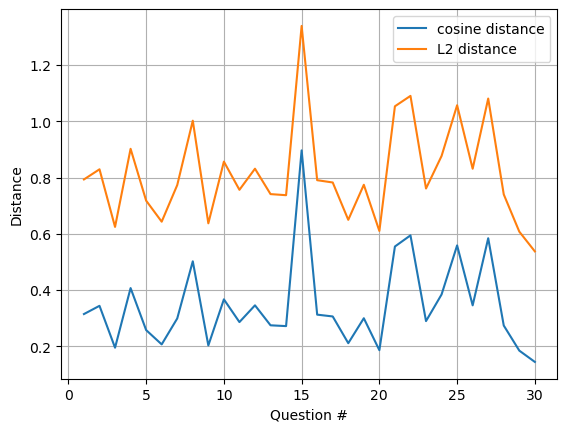

In [14]:
distance(embedding_Q[:30],embedding_A[:30])

In [15]:


print(1 - F.cosine_similarity(embedding_Q[np.random.randint(1,250)], embedding_Q[np.random.randint(1,250)],dim=0))
print(torch.norm((embedding_Q[np.random.randint(1,250)] - embedding_Q[np.random.randint(1,250)]),p=2))
print(torch.sum(torch.abs(embedding_Q[np.random.randint(1,250)] - embedding_A[np.random.randint(1,250)])))



tensor(0.9697)
tensor(1.3622)
tensor(22.1717)


In [16]:
def closest_neighbors(embedding_Q,embedding_A,k): 
    answer_is_near = 0
    embedding = torch.cat([embedding_Q,embedding_A],dim=0)
    for i in range(len(embedding_Q)): 
        distances, indices = torch.topk(-torch.norm(embedding[i] - embedding,dim=1),k)
        if torch.isin(i+len(embedding_Q),indices): 
            answer_is_near += 1
    return answer_is_near/len(embedding_Q)

print(embedding_Q[:50].shape)

print(closest_neighbors(embedding_Q[:50],embedding_A[:50],2))
        


torch.Size([50, 384])
0.76


## Testing the code 

# Ablation

We will now test our code that implements activation patching and ablation. For now, we just test it on random neurons and MLP layers to see whether the fraction of questions containing their answers as nearest neighbors have changed appreciably. 



In [17]:
ablated_questions = ablation([3,4,5],list(range(50,360)),questions[:50],type="zero")
ablated_answers = ablation([3,4,5],list(range(50,360)),answers[:50],type="zero")

print(closest_neighbors(ablated_questions,ablated_answers,2))



0.26


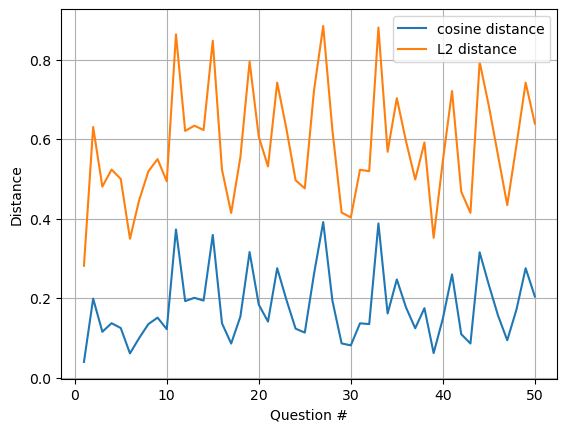

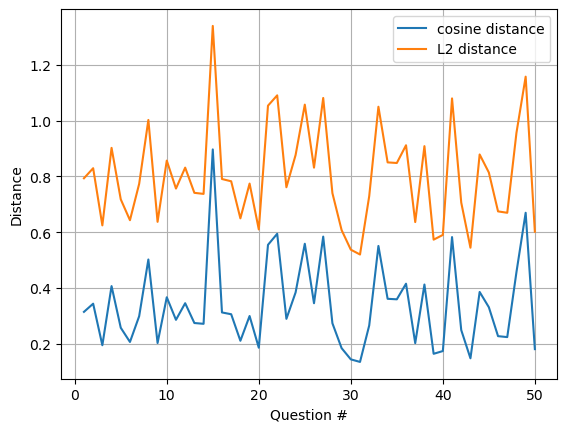

In [18]:
distance(ablated_questions,ablated_answers)
distance(embedding_Q[:50],embedding_A[:50])



# Activation patching



In [50]:
orig_prompt = answers[7]
corr_prompt = answers[4]

max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

tokenizers = tokenizer([orig_prompt, corr_prompt],padding='max_length',max_length=max_tokens,truncation=True,return_tensors='pt')

embedding1 = embed(orig_prompt,model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
embedding2 = embed(corr_prompt,model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

print(F.cosine_similarity(embedding1, embedding2), torch.norm(embedding1 - embedding2, p=2))
print(activation_patching(orig_prompt,corr_prompt,[0,1,2,3],[i for i in range(200)],type="MLP"))
print(model.encoder.layer[3]._forward_hooks)

tensor([0.2669]) tensor(1.2109)
(tensor([0.2430]), tensor(0.6971))
OrderedDict()


## Identifying which parts of a model are most relevant for relating the answer to the question

There are various ways to attempt to identify how the model encodes meaning into text (such as answers and questions). If we find out how information about semantic meaning flows through the transformer, we can begin to identify relevant circuits within the model. In the case of studying answers and questions, it would be interesting to attempt to identify which parts of the model are most relevant for relating the answer to the question - in other words, how does the relationship between the embedding of the question and answer change as information flows through the model? 

In this section, I attempt to write a function that allows us to plot how the distance between the question and answer embeddings change as we do a forward propagation on the answer. This could potentially be useful for identifying relevant circuits in the future, especially when we combine this analysis with ablation and activation patching. This analysis is inspired by the related concept of "logit lens" in the case of decoder models (see https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=nMCxqqvr7fbM)

In [20]:
def intermediate_embeddings(text):

    intermediate_act_mlp = []
    intermediate_act_attn = []
    intermediate_embeddings_mlp = []
    intermediate_embeddings_attn = []

    def hook_mlp(module,inp,out): 
        intermediate_act_mlp.append(out)
    def hook_attn(module,inp,out): 
        intermediate_act_attn.append(out)
    for i in range(num_layers): 
        model.encoder.layer[i].output.register_forward_hook(hook_mlp)     #mlp.layernorm
        model.encoder.layer[i].attention.output.register_forward_hook(hook_attn)     #attention.output
    text_embedding = embed(text,model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    intermediate_embeddings_mlp = torch.stack([F.normalize(mean_pooling(intermediate_act_mlp[i],tokenizer(text, padding = True, truncation=True, return_tensors='pt')["attention_mask"]), p=2,dim=1) for i in range(num_layers)])
    intermediate_embeddings_attn = torch.stack([F.normalize(mean_pooling(intermediate_act_attn[i],tokenizer(text, padding = True, truncation=True, return_tensors='pt')["attention_mask"]), p=2,dim=1) for i in range(num_layers)])

    return intermediate_embeddings_mlp, intermediate_embeddings_attn

intermediate_embeddings_mlp, intermediate_embeddings_attn = intermediate_embeddings("hallo")
print(model(**tokenizer(questions[:5], padding = True, truncation=True, return_tensors='pt'))[0].shape)
print(intermediate_embeddings_mlp.shape)
print(intermediate_embeddings_attn.shape)
print(embed("hallo",model,tokenizer("hallo", padding = True, truncation=True, return_tensors='pt')).shape)

torch.Size([5, 84, 384])
torch.Size([6, 1, 384])
torch.Size([6, 1, 384])
torch.Size([1, 384])


diff shape: torch.Size([6, 1, 384])
<class 'torch.Tensor'>
torch.Size([6, 1])


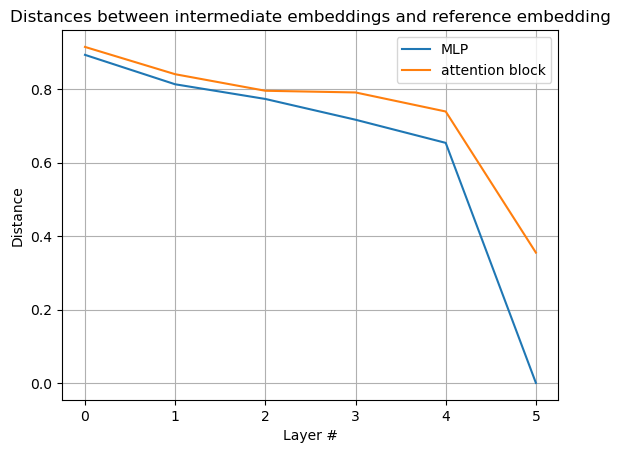

In [21]:
def embedding_distance(reference_text,text): 
    reference_embedding = embed(reference_text,model,tokenizer(reference_text, padding = True, truncation=True, return_tensors='pt'))

    intermediate_embeddings_mlp,intermediate_embeddings_attn = intermediate_embeddings(text)
    print("diff shape:", (reference_embedding - intermediate_embeddings_mlp).shape)
    distances_mlp = 1 - F.cosine_similarity(reference_embedding,intermediate_embeddings_mlp,dim=2)                               #torch.norm(reference_embedding - intermediate_embeddings_mlp,dim=2)
    print(type(distances_mlp))
    print(distances_mlp.shape)
    distances_attn = 1 - F.cosine_similarity(reference_embedding,intermediate_embeddings_attn,dim=2)                                 #torch.norm(reference_embedding - intermediate_embeddings_attn,dim=2)

    plt.plot(range(num_layers),distances_mlp,label="MLP")
    plt.plot(range(num_layers),distances_attn,label="attention block")
    plt.legend()
    plt.xlabel("Layer #")
    plt.ylabel("Distance")
    plt.grid()
    plt.title("Distances between intermediate embeddings and reference embedding")
    plt.show()

embedding_distance(answers[18],answers[18])

## Finding the most important activations

In order to know which features are most important for the circuits, we need to visualize the activations within the model. That is what we will implement now. 

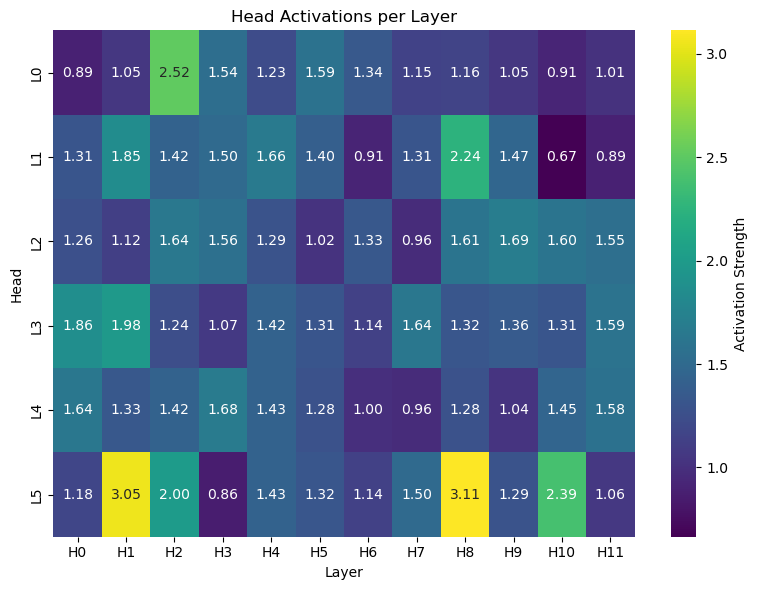

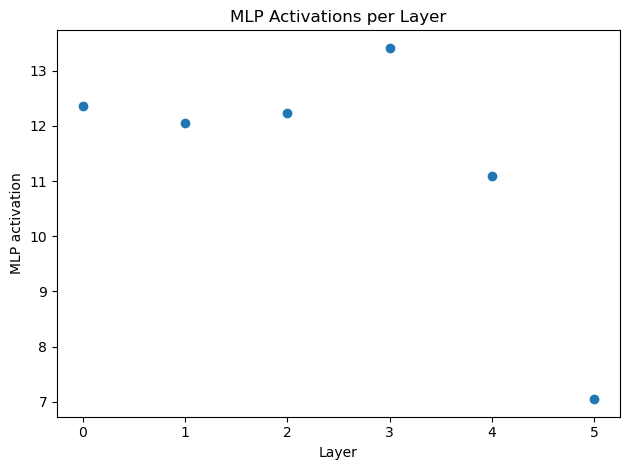

In [22]:
import math
import seaborn as sns

def activations(text): 

    def patch_attention_heads(model, layer_idx):
        attn = model.encoder.layer[layer_idx].attention.self
        attn.original_forward = attn.forward

        def forward(self, hidden_states, *args, **kwargs):
            mixed_query_layer = self.query(hidden_states)
            mixed_key_layer = self.key(hidden_states)
            mixed_value_layer = self.value(hidden_states)

            query_layer = self.transpose_for_scores(mixed_query_layer)
            key_layer = self.transpose_for_scores(mixed_key_layer)
            value_layer = self.transpose_for_scores(mixed_value_layer)

            # Take the dot product between "query" and "key" to get the raw attention scores.
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
            attention_scores = attention_scores/math.sqrt(self.attention_head_size)

            # Normalize the attention scores to probabilities.
            attention_probs = F.softmax(attention_scores,dim=-1)

            # This is actually dropping out entire tokens to attend to, which might
            # seem a bit unusual, but is taken from the original Transformer paper.
            attention_probs = self.dropout(attention_probs)

            context_layer = torch.matmul(attention_probs, value_layer)
            self.per_head_output = context_layer.detach()

            context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
            new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
            context_layer = context_layer.view(*new_context_layer_shape)

            outputs = (context_layer, attention_probs)
            return outputs
        attn.forward = MethodType(forward, attn)

    mlp_output = []
    handles = []
    def hook_mlp(module, inp, out): 
        mlp_output.append(out)
    for i in range(num_layers): 
        patch_attention_heads(model, i)
        handles.append(model.encoder.layer[i].output.register_forward_hook(hook_mlp))
    embed(text,model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    attention_head_act = np.array([torch.norm((model.encoder.layer[i].attention.self.per_head_output), p = 2,dim=-1).mean(dim=[0,2]) for i in range(num_layers)])
    mlp_act = np.array([torch.norm((mlp_output[i]), p = 2,dim=-1).mean(dim=[0,1]) for i in range(num_layers)])
    for i in range(num_layers): 
        handles[i].remove()
        model.encoder.layer[i].attention.self.forward = model.encoder.layer[i].attention.self.original_forward
    
    #Plotting attention head activations for every layer
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_head_act, cmap='viridis', annot=True, fmt=".2f", 
            xticklabels=[f"H{i}" for i in range(attention_head_act.shape[1])],
            yticklabels=[f"L{i}" for i in range(attention_head_act.shape[0])],
            cbar_kws={"label": "Activation Strength"})
    plt.title("Head Activations per Layer")
    plt.xlabel("Layer")
    plt.ylabel("Head")
    plt.tight_layout()
    plt.show()

    plt.plot(range(num_layers),mlp_act,"o")
    plt.title("MLP Activations per Layer")
    plt.xlabel("Layer")
    plt.ylabel("MLP activation")
    plt.tight_layout()
    plt.show()

activations(answers[1])

